## Six-bar Mechanism Balancing

In [1]:
from BetaShF import ShF
from BetaShM import ShM 
import numpy as np 
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from cnsg_differential_evolution import cnsg_differential_evolution

### Contraints

$-0.16m <= x_{cn},y_{cn} <= 0.16m$

$0.005m <= t_{cn} <= 0.04m$

### Objective Function

In [2]:
def objective_function(s, ShF, ShM): #c is a constant that distributes the weight among the functions.
    c = 0.5
    return c*ShF(s) + c*ShM(s)

### Gradient Descent

In [3]:

eps = 1e-5
def Vf(X,ShF,ShM,f):
    n = len(X)
    G = np.zeros((n),float)
    incX = np.zeros((n),float)
    for i in range(n):
        incX[i] = eps
        G[i] = (f(X+incX,ShF, ShM)-f(X,ShF, ShM))/eps
        incX[i] = 0
    return G

def VfTd(X,ShF, ShM,d,f):
    return (f(X+eps*d,ShF, ShM,)-f(X,ShF, ShM,))/eps

def V2f(X,ShF,ShM,f):
    n = len(X)
    H = np.zeros((n,n),float)
    incX = np.zeros((n),float)
    for i in range(n):
        incX[i] = eps
        H[:,i] = (Vf(X+incX,ShF,ShM,f)-Vf(X,ShF,ShM,f))/eps
        incX[i] = 0
    return H

def V2fTd(X,ShF, ShM,d,f):
    return (Vf(X+eps*d,ShF, ShM,f)-Vf(X,ShF, ShM,f))/eps
    
# X = np.array([2,3])
# d = np.array([5,1])


# print("P_k: ", d)

# print('f:',objective_function(bestSol.x,ShF, ShM))
# print('Vf:',Vf(bestSol.x, ShF, ShM,objective_function))
# print('V2f:',V2f(bestSol.x, ShF, ShM,objective_function))
# print('VfTd:',VfTd(bestSol.x, ShF, ShM,d,objective_function))
# print('V2fTd:',V2fTd(bestSol.x, ShF, ShM,d,objective_function))

In [4]:
def calculate_d(X):
    return -Vf(X,ShF,ShM,objective_function)/np.linalg.norm(Vf(X, ShF, ShM, objective_function))

In [20]:
def gradient_descent(x0, f, max_iter = 4, eps = 1e-5):
    k=0
    x = x0
    G = Vf(x,ShF, ShM, f)
    normG = np.linalg.norm(G)
    P = -G
    fit = f(x, ShF, ShM)
    while(k <= max_iter and np.linalg.norm(Vf(x, ShF, ShM,f)) >= eps ):
        print("#---->",k)
        # Calculate step size a_k
        a = np.dot(-P, G)/np.dot(P,V2fTd(x,ShF, ShM,P,f))
        x = x + a*P
        # Calculate the direction P_k
        P = -Vf(x,ShF,ShM,f)/np.linalg.norm(Vf(x, ShF, ShM, f))

        G_ = np.copy(G)
        G = G + a*V2fTd(x,ShF, ShM,P,f)
        normG = np.linalg.norm(G)
        B = -np.dot(G,G)/np.dot(G_,G_)
        P = -G + B*P
        k = k+1

        print("**: ",x," - ",f(x,ShF,ShM))
        if f(x,ShF,ShM) >= fit:
            break
        #fit = min(f(x,ShF,ShM), fit)
        fit = f(x,ShF,ShM)
    return x

### Differential Evolution

In [6]:
# Bounds for each variable
nVar = 5
bounds = []
for i in range(1,nVar*3+1):
    if(i%3==0): bounds.append([0.005,0.04])
    else: bounds.append([-0.16, 0.16])
bounds = np.array(bounds)
print('bounds',bounds)


bounds [[-0.16   0.16 ]
 [-0.16   0.16 ]
 [ 0.005  0.04 ]
 [-0.16   0.16 ]
 [-0.16   0.16 ]
 [ 0.005  0.04 ]
 [-0.16   0.16 ]
 [-0.16   0.16 ]
 [ 0.005  0.04 ]
 [-0.16   0.16 ]
 [-0.16   0.16 ]
 [ 0.005  0.04 ]
 [-0.16   0.16 ]
 [-0.16   0.16 ]
 [ 0.005  0.04 ]]


In [7]:
s=bounds[:,0]
r = objective_function(s, ShF, ShM)
print('OF:',r)

OF: 46.604883632565645


In [8]:
def callback(s,convergence=2):
    print('callback',s)

In [21]:
it = 100
n = 1
sols = np.zeros((n, 2))
best, bestSol = 10, None
for i in range(n):
    #r = differential_evolution(objective_function, bounds,popsize=100, args=(ShF, ShM), maxiter=it,callback=callback, polish = False)
    r = cnsg_differential_evolution(objective_function,bounds,args=(ShF, ShM),popsize=15,MaxGenerations=it)
    print('r',r)
    sols[i][0], sols[i][1] = ShF(r), ShM(r)
    fitness = objective_function(r,ShF,ShM)
    print("OF: ", fitness)
    if fitness < 1:
        #r = gradient_descent(r,calculate_d(r), Vf, VfTd, V2f, V2fTd)
        r = gradient_descent(r,objective_function)
        print("after GD -> ", r)
    if fitness < best:
        best = fitness
        bestSol = r

r [-0.04507875 -0.01666331  0.02396269 -0.08581049  0.01147232  0.01981688
 -0.05236916  0.00465119  0.04       -0.00775014  0.00727128  0.00573405
  0.00593693 -0.00223985  0.00532005]
OF:  0.5655316142243235
#----> 0
**:  [-0.04432088 -0.01647868  0.02346075 -0.0861854   0.01097543  0.02025638
 -0.05243995  0.00467827  0.04020001 -0.00763178  0.00714985  0.00558514
  0.00584203 -0.00220057  0.00525994]  -  0.560178232093879
#----> 1
**:  [-0.04365805 -0.01630433  0.02297831 -0.08660633  0.01065672  0.02079378
 -0.05248821  0.00468574  0.04033552 -0.00754694  0.0070632   0.0054785
  0.0057774  -0.00217383  0.005219  ]  -  0.5660957822907502
after GD ->  [-0.04365805 -0.01630433  0.02297831 -0.08660633  0.01065672  0.02079378
 -0.05248821  0.00468574  0.04033552 -0.00754694  0.0070632   0.0054785
  0.0057774  -0.00217383  0.005219  ]


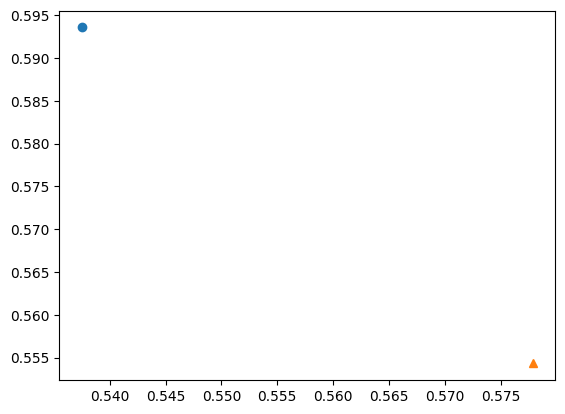

In [22]:
np.savetxt('Solutions.txt', sols, delimiter=', ')   # X is an array

plt.plot(sols[:, 0], sols[:, 1], 'o')
plt.plot(ShF(bestSol), ShM(bestSol), '^')